In [1]:
# Importing
import theano.tensor as T
import sys, os
sys.path.append("../GeMpy")
sys.path.append("../pygeomod")

import GeMpy_core
import Visualization

import importlib
importlib.reload(GeMpy_core)
importlib.reload(Visualization)
import numpy as np
import pandas as pn
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
np.set_printoptions(precision = 6, linewidth= 130, suppress =  True)

%matplotlib inline
#%matplotlib notebook

Using gpu device 0: GeForce GTX 970 (CNMeM is disabled, cuDNN not available)


# Sandstone Model

First we make a GeMpy instance with most of the parameters default (except range that is given by the project). Then we also fix the extension and the resolution of the domain we want to interpolate. Finally we compile the function, only needed once every time we open the project (the guys of theano they are working on letting loading compiled files, even though in our case it is not a big deal).

*General note. So far the reescaling factor is calculated for all series at the same time. GeoModeller does it individually for every potential field. I have to look better what this parameter exactly means*

In [ ]:
# Setting extend, grid and compile
# Setting the extent
sandstone = GeMpy_core.GeMpy()

# Create Data class with raw data
sandstone.import_data( 696000,747000,6863000,6950000,-20000, 2000,
                                     path_f = os.pardir+"/input_data/a_Foliations.csv",
                                     path_i = os.pardir+"/input_data/a_Points.csv")

sandstone.Data.set_series({"EarlyGranite_Series":sandstone.Data.formations[-1], 
                      "BIF_Series":(sandstone.Data.formations[0], sandstone.Data.formations[1]),
                      "SimpleMafic_Series":sandstone.Data.formations[2]}, 
                       order = ["EarlyGranite_Series",
                              "BIF_Series",
                              "SimpleMafic_Series"]) 

All input data is stored in pandas dataframes under, ```self.Data.Interances``` and ```self.Data.Foliations```:

In [22]:
sandstone.Data.Foliations;

In [23]:
# Create a class Grid so far just regular grid
sandstone.create_grid()
sandstone.Grid.grid

array([[  696000.      ,  6863000.      ,   -20000.      ],
       [  696000.      ,  6863000.      ,   -19551.019531],
       [  696000.      ,  6863000.      ,   -19102.041016],
       ..., 
       [  747000.      ,  6950000.      ,     1102.040771],
       [  747000.      ,  6950000.      ,     1551.020386],
       [  747000.      ,  6950000.      ,     2000.      ]], dtype=float32)

## Plotting raw data

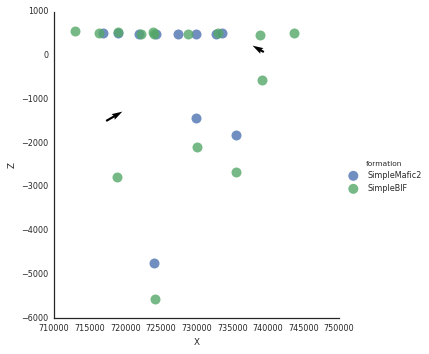

In [19]:
sandstone.Plot.plot_data(serie = sandstone.Data.series.columns.values[1])

## Class Interpolator

This class will take the data from the class Data and calculate potential fields and block

In [24]:
sandstone.set_interpolator()

##  Early granite

/home/miguel/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1288: UserWarning: findfont: Font family ['Times New Roman'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


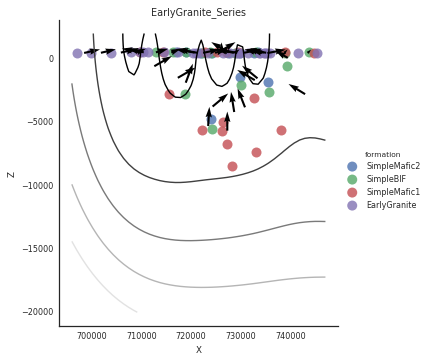

In [26]:
sandstone.Plot.plot_potential_field(10, n_pf=0)

## BIF Series

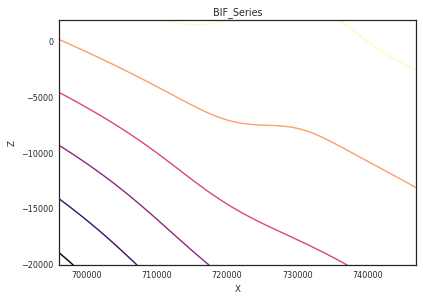

In [31]:
sandstone.Plot.plot_potential_field(10, n_pf=1, cmap = "magma",  plot_data = False)

##  SImple mafic

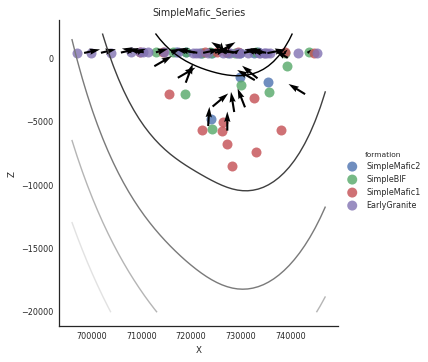

In [29]:
sandstone.Plot.plot_potential_field(10, n_pf=2)

# Optimizing the export of lithologies

Here I am going to try to return from the theano interpolate function the internal type of the result (in this case DK I guess) so I can make another function in python I guess to decide which potential field I calculate at every grid_pos 

In [34]:
# Reset the block
sandstone.Interpolator.block.set_value(np.zeros_like(sandstone.Grid.grid[:,0]))

# Compute the block
sandstone.Interpolator.compute_block_model([0,1,2], verbose = 1)

4
[1 1 1 ..., 1 1 1] 0
The serie formations are EarlyGranite
[1 2]
[1 1 1 ..., 1 1 1] 10967
The serie formations are SimpleMafic2|SimpleBIF
3
[1 1 1 ..., 1 1 1] 13089
The serie formations are SimpleMafic1


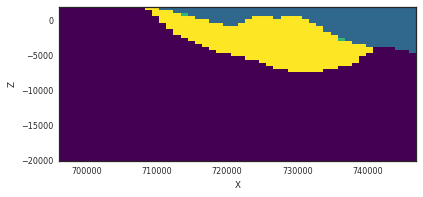

In [35]:
sandstone.Plot.plot_block_section()

# Export vtk

In [14]:
"""Export model to VTK

Export the geology blocks to VTK for visualisation of the entire 3-D model in an
external VTK viewer, e.g. Paraview.

..Note:: Requires pyevtk, available for free on: https://github.com/firedrakeproject/firedrake/tree/master/python/evtk

**Optional keywords**:
    - *vtk_filename* = string : filename of VTK file (default: output_name)
    - *data* = np.array : data array to export to VKT (default: entire block model)
"""
vtk_filename = "noddyFunct2"

extent_x = 10
extent_y = 10
extent_z = 10

delx = 0.2
dely = 0.2
delz = 0.2
from pyevtk.hl import gridToVTK
# Coordinates
x = np.arange(0, extent_x + 0.1*delx, delx, dtype='float64')
y = np.arange(0, extent_y + 0.1*dely, dely, dtype='float64')
z = np.arange(0, extent_z + 0.1*delz, delz, dtype='float64')

# self.block = np.swapaxes(self.block, 0, 2)
gridToVTK(vtk_filename, x, y, z, cellData = {"geology" : sol})

ImportError: No module named 'pyevtk'

# Performance Analysis

## CPU

In [32]:
%%timeit
sol =  interpolator.geoMigueller(dips,dips_angles,azimuths,polarity, rest, ref)[0]

10 loops, best of 3: 46.8 ms per loop


In [172]:
sandstone.block_export.profile.summary()

Function profiling
  Message: /home/bl3/PycharmProjects/GeMpy/GeMpy/GeoMig.py:778
  Time in 12 calls to Function.__call__: 1.747251e+01s
  Time in Function.fn.__call__: 1.746418e+01s (99.952%)
  Time in thunks: 1.695012e+01s (97.010%)
  Total compile time: 8.084836e+00s
    Number of Apply nodes: 358
    Theano Optimizer time: 7.368957e+00s
       Theano validate time: 3.972366e-01s
    Theano Linker time (includes C, CUDA code generation/compiling): 4.228358e-01s
       Import time 0.000000e+00s

Time in all call to theano.grad() 0.000000e+00s
Time since theano import 4116.375s
Class
---
<% time> <sum %> <apply time> <time per call> <type> <#call> <#apply> <Class name>
  51.6%    51.6%       8.746s       6.57e-03s     C     1332     111   theano.tensor.elemwise.Elemwise
  21.5%    73.1%       3.647s       2.76e-02s     C      132      11   theano.tensor.basic.Alloc
   9.1%    82.2%       1.545s       4.29e-02s     Py      36       3   theano.tensor.basic.Nonzero
   6.9%    89.1%      

## GPU

In [20]:
%%timeit
# Reset the block
sandstone.block.set_value(np.zeros_like(sandstone.grid[:,0]))

# Compute the block
sandstone.compute_block_model([0,1,2], verbose = 0)

1 loop, best of 3: 1.51 s per loop


In [22]:
sandstone.block_export.profile.summary()

Function profiling
  Message: /home/miguel/PycharmProjects/GeMpy/GeMpy/GeoMig.py:791
  Time in 15 calls to Function.__call__: 7.831817e+00s
  Time in Function.fn.__call__: 7.828252e+00s (99.954%)
  Time in thunks: 7.533441e+00s (96.190%)
  Total compile time: 1.917513e+01s
    Number of Apply nodes: 468
    Theano Optimizer time: 4.435555e+00s
       Theano validate time: 4.534802e-01s
    Theano Linker time (includes C, CUDA code generation/compiling): 1.452507e+01s
       Import time 3.308706e-01s

Time in all call to theano.grad() 0.000000e+00s
Time since theano import 1392.894s
Class
---
<% time> <sum %> <apply time> <time per call> <type> <#call> <#apply> <Class name>
  69.2%    69.2%       5.213s       3.48e-01s     C       15       1   theano.sandbox.cuda.basic_ops.GpuAdvancedIncSubtensor1
  13.1%    82.3%       0.988s       7.49e-04s     C     1320      88   theano.tensor.elemwise.Elemwise
   4.3%    86.6%       0.322s       2.15e-03s     C      150      10   theano.tensor.blas